# Import things

In [30]:
from skimage.filters import gabor_kernel
from skimage import io
import matplotlib.pyplot as plt 
import numpy as np
import os
import tensorflow as tf
import math
%matplotlib inline

# Plot a test gabor

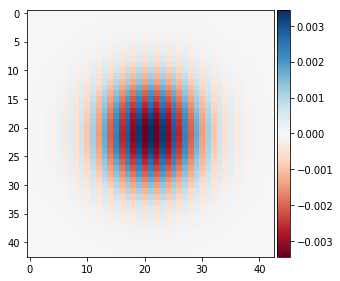

43


In [31]:
bandwidths = (.16,.24,.32,.48,.9,1.6)#makes each filter 43x43
sfs = (1/2.,1/3.,1/4.,1/6.,1/11.,1/18.)
sig=6.8
i=0
gk = gabor_kernel(frequency=sfs[i],theta=math.pi*2.*(0/16.),sigma_x=sig,sigma_y=sig)
plt.figure()        
io.imshow(gk.real)  
io.show() 
print(len(gk.real))

 ## WHOOOOOOOO!!!! FUCKIN YEAH STRIPES

Iteration step: 23


AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

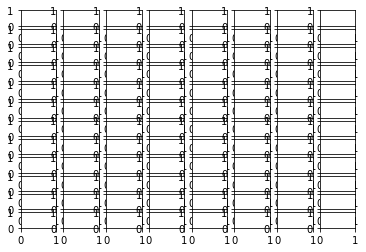

In [32]:
def plot_conv1_kernels(data, step):
    """
    Plots the 96 conv1 kernels in a 12 x 8 subplot grid.
    
    You will need to EDIT this function.
    """
    print('Iteration step: %d' % step)
    kernels = data
    ### YOUR CODE HERE
    for kernelID in range(kernels.shape[1]):
        kernel = kernels[:,kernelID:]
        fig, ax = plt.subplots(12,8)
        ax[kernelID].imshow(kernel)
    ax.show()
    ### END OF YOUR CODE
    
plot_conv1_kernels(gk, 23)

In [34]:
def gabor_model(inputs, train=True, norm=True, **kwargs):
    """
    Hard-coded one-layer network with a convolutional layer of gabor filters followed by relu, 
    max pooling and local response normalization.
    
    """
    # propagate input targets
    outputs = inputs
    dropout = .5 if train else None
    input_to_network = inputs['images']
    
    with tf.variable_scope('conv1') as scope:
        #will be 96 43x43 filters with 6 spatial frequencies and 16 orientations
        weights = tf.get_variable(shape=[43, 43, 3, 96], dtype=tf.float32, 
                                  initializer=gabor_initializer(), name='weights')
        conv = tf.nn.conv2d(input_to_network, weights,[1, 6, 6, 1], padding='SAME')#want to produce ~30x30 outputs
        biases = tf.Variable(tf.constant(0.0, shape=[96], dtype=tf.float32), trainable=True, name='biases')
        bias = tf.nn.bias_add(conv, biases)
        relu = tf.nn.relu(bias, name='relu')
        pool = tf.nn.max_pool(value=relu, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding='SAME', name='pool')
        lrn = tf.nn.local_response_normalization(pool, depth_radius=5, bias=2, alpha=.0001, beta=.75) # bias=Kappa?
       
        outputs['conv1_kernel'] = weights
        outputs['conv1'] = lrn
        
    with tf.variable_scope('fc2') as scope:
        weights = tf.get_variable(shape=[9600,1000], dtype=tf.float32, 
                                  initializer=tf.contrib.layers.xavier_initializer(), name='weights')
        biases = tf.Variable(tf.constant(0, shape=[1000], dtype=tf.float32), trainable=True, name='biases')
        fc = tf.nn.xw_plus_b(outputs['fc7'], weights, biases)
        outputs['pred'] = fc
    
    ### END OF YOUR CODE
    for k in ['conv1', 'conv1_kernel', 'pred']:
        assert k in outputs, '%s was not found in outputs' % k

    return outputs, {}

def gabor_initializer():
    kernels = numpy.zeros((43,43,3,96))
    for sfIndex,spatFreq in enumerate((1/2, 1/3, 1/4, 1/6, 1/11, 1/18)
        for oriIndex,orientation in enumerate(range(1,16))
            newKernel = gabor_kernel(frequency=spatFreq,theta=math.tau*(orientation/16))
            newKernel = newKernel.real
            kernels(:,:,:,sfIndex*16+oriIndex)=newKernel
    return kernels

SyntaxError: invalid syntax (<ipython-input-34-dc36d5791329>, line 43)

# Test model in tf

In [ ]:
import tensorflow as tf
import numpy as np

# input placeholder
input_placeholder = tf.placeholder(tf.float32, shape=[None, 5])
# trainable variables randomly initialized
W1 = tf.Variable(tf.random_normal(shape=[5,20]), tf.float32)
b1 = tf.Variable(tf.random_normal(shape=[20,]), tf.float32)
W2 = tf.Variable(tf.random_normal(shape=[20,5]), tf.float32)
b2 = tf.Variable(tf.random_normal(shape=[5,]), tf.float32)
# hidden layer
h = tf.nn.sigmoid(tf.matmul(input_placeholder, W1) + b1)
# output
out = tf.matmul(h, W2) + b2

In [ ]:
#Initialize variables and create session
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
# creates a session and allocates memory on GPU 1
sess = tf.Session()
# initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [ ]:
# create some random input and run forward pass on it
inp = np.random.rand(1, 5).astype(np.float32)
result = sess.run(out, feed_dict={input_placeholder: inp})
print(result)

In [ ]:
#Train the network to optimize a function y

# the input x and output y
x = np.random.rand(1000,5).astype(np.float32)
y = x ** 3 + 17
# labels placeholder
labels_placeholder = tf.placeholder(tf.float32, shape=[None, 5])
# simple l2-loss
loss = tf.nn.l2_loss(out - labels_placeholder)
# Gradient descent optimizer
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

In [ ]:
#train for 1000 steps

from tqdm import trange
for i in trange(1000):
    idx = np.random.RandomState(0).permutation(1000)[:32]
    inputs = x[idx]
    labels = y[idx]
    sess.run(train_step, feed_dict={input_placeholder: inputs, labels_placeholder: labels})

In [ ]:
inp = np.random.rand(1, 5).astype(np.float32)
ground_truth = inp ** 3 + 17
prediction = sess.run(out, feed_dict={input_placeholder: inp})
print('Ground truth', ground_truth) 
print('Prediction', prediction)

In [ ]:
print tf.size(W2)

In [ ]:
def gabor_initializer():
    kernels = np.zeros((43,43,3,96))
    bandwidths = (.16,.24,.32,.48,.9,1.6)#makes each filter 43x43
    for sfIndex,spatFreq in enumerate((1/2., 1/3., 1/4., 1/6., 1/11., 1/18.)):
        for oriIndex,orientation in enumerate(range(1,17)):
            newKernel = gabor_kernel(frequency=spatFreq,theta=math.pi*2.*(orientation/16.),bandwidth=bandwidths[sfIndex])
            newKernel = newKernel.real
            kernels[:,:,:,sfIndex*16+oriIndex]=np.zeros((43,43,3))
            mismatch = 43-len(newKernel)
            border = int(np.floor(mismatch/2.))
            kernels[border:border+len(newKernel),border:border+len(newKernel),0,sfIndex*16+oriIndex]=newKernel
            kernels[border:border+len(newKernel),border:border+len(newKernel),1,sfIndex*16+oriIndex]=newKernel
            kernels[border:border+len(newKernel),border:border+len(newKernel),2,sfIndex*16+oriIndex]=newKernel
    return kernels

In [ ]:
test_bank = gabor_initializer()
plt.figure()        
io.imshow(test_bank[:,:,1,3])  
io.show() 

In [ ]:
bandwidths = (.16,.24,.32,.48,.9,1.6)#makes each filter 43x43
bandwidths[2]

In [ ]:
for i,j in enumerate(range(1,16)):
    print(i,j)

In [ ]:
for x in np.arange(0,2*math.pi,0.1):
   gk = gabor_kernel(frequency=1/2.,theta=x,sigma_x=2,sigma_y=2)
   print(gk.shape)

In [ ]:
# test images
n_images = 3
resolution = 227
channel = 3
images = tf.Variable(tf.truncated_normal([n_images,resolution,resolution,channel]))
labels = np.random.permutation(range(n_images))
inputs = {'images': images,
         'labels': labels}

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
images_array = inputs['images'].eval(sess)
labels_array = inputs['labels'].eval(sess)
sess.close()
plt.imshow(images_array[1,::])
#labels_array.shape

In [ ]:
test = [[1 2][3 4]]

In [ ]:
def gabor_initializer():
    kernels = numpy.zeros((43,43,3,96))
    for sfIndex,spatFreq in enumerate((1/2, 1/3, 1/4, 1/6, 1/11, 1/18)
        for oriIndex,orientation in enumerate(range(1,16))
            newKernel = gabor_kernel(frequency=spatFreq,theta=math.tau*(orientation/16))
            newKernel = newKernel.real
            kernels(:,:,:,sfIndex*16+oriIndex)=newKernel
    return kernels
                                    

In [ ]:
import sys
sys.path.append('assignment1')
%matplotlib inline
import tensorflow as tf
from tfutils import base, data, model, optimizer, utils
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gabor_kernel
from skimage import io 
import math
from dldata.metrics.utils import compute_metric_base

In [38]:
## Testing the model

In [39]:
import sys
sys.path.append('assignment1')
%matplotlib inline
import tensorflow as tf
from tfutils import base, data, model, optimizer, utils
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gabor_kernel
from skimage import io 
import math
from dldata.metrics.utils import compute_metric_base

In [40]:
# test images
n_images = 3
resolution = 227
channel = 3
images = tf.Variable(tf.truncated_normal([n_images,resolution,resolution,channel]))
labels = np.random.permutation(range(n_images))
inputs = {'images': images,
         'labels': labels}

In [41]:
import pymongo as pm
connection = pm.MongoClient(port=24444)
connection.database_names()
db = connection['assignment1']
col1 = db['alexnet.files']
exp_out = list(col1.find({'exp_id': '1st_experiment'}))

In [42]:
from dataprovider import ImageNetDataProvider

In [43]:
from models import gabor_model
#from skimage.filters import gabor_kernel #tried this here for shits, didn't help
model_layers, _ = gabor_model(inputs)
out = model_layers['pred']